# Importing libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import time
import matplotlib
from matplotlib import pyplot as plt
import copy

# Installing DCLS and importing Dcls2d

In [ ]:
!pip3 install dcls
from DCLS.construct.modules import  Dcls2d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Fine-tuning a ConvNeXt-T model on STL-10 dataset

In [ ]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transforms for the dataset
transform = transforms.Compose([
    transforms.RandomCrop(96, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load STL-10 dataset
train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.STL10(root='./data', split='test', download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 2640397119/2640397119 [02:38<00:00, 16614300.68it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# ConvNeXt model
class Block(nn.Module):
    r""" ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch

    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)),
                                    requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = torchvision.ops.StochasticDepth(p=drop_path, mode='row') if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

class ConvNeXt(nn.Module):
    r""" ConvNeXt
        A PyTorch impl of : `A ConvNet for the 2020s`  -
          https://arxiv.org/pdf/2201.03545.pdf

    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    def __init__(self, in_chans=3, num_classes=1000,
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0.,
                 layer_scale_init_value=1e-6, head_init_scale=1.,
                 ):
        super().__init__()

        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j],
                layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape, )

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x


model_urls = {
    "convnext_tiny_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth",
    "convnext_dcls_gauss_tiny_1k": "https://zenodo.org/record/8029747/files/convnext_dcls_gauss_tiny_1k_224_ema.pth",
}

def load_checkpoint(model, checkpoint_name='convnext_tiny_1k'):
    url = model_urls[checkpoint_name]
    checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu", check_hash=True)
    print(model.load_state_dict(checkpoint["model"]))

def convnext_tiny(pretrained=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], **kwargs)
    if pretrained:
        url = model_urls['convnext_tiny_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu", check_hash=True)
        model.load_state_dict(checkpoint["model"])
    return model

In [ ]:
# Load pre-trained ConvNeXt-T model
model = convnext_tiny(pretrained=True)
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters of the model: {n_parameters/1e6:.2f} M")

Number of parameters of the model: 28.59 M


In [ ]:
# Freeze all the layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Replace the last fully connected layer to match the number of classes in STL-10
num_classes = 10
model.head = nn.Linear(768, num_classes)
model.to(device)

ConvNeXt(
  (downsample_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm()
    )
    (1): Sequential(
      (0): LayerNorm()
      (1): Conv2d(96, 192, kernel_size=(2, 2), stride=(2, 2))
    )
    (2): Sequential(
      (0): LayerNorm()
      (1): Conv2d(192, 384, kernel_size=(2, 2), stride=(2, 2))
    )
    (3): Sequential(
      (0): LayerNorm()
      (1): Conv2d(384, 768, kernel_size=(2, 2), stride=(2, 2))
    )
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=96, out_features=384, bias=True)
        (act): GELU(approximate='none')
        (pwconv2): Linear(in_features=384, out_features=96, bias=True)
        (drop_path): Identity()
      )
      (1): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.head.parameters(), lr=0.001)

In [ ]:
# Define a train loop
def train_and_test(model, criterion, optimizer):
  start_time = time.time()
  # Training loop
  num_epochs = 10
  stats_dict = dict(train_loss = [], train_acc = [], test_loss = [], test_acc = [])
  for epoch in range(num_epochs):
      model.train()  # Set model to training mode
      running_loss = 0.0
      correct = 0
      total = 0

      for images, labels in train_loader:
          images = images.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          _, predicted = outputs.max(1)
          total += labels.size(0)
          correct += predicted.eq(labels).sum().item()

      train_loss = running_loss / len(train_loader)
      train_acc = 100.0 * correct / total

      # Evaluate on the test set
      model.eval()  # Set model to evaluation mode
      test_loss = 0.0
      correct = 0
      total = 0

      with torch.no_grad():
          for images, labels in test_loader:
              images = images.to(device)
              labels = labels.to(device)

              outputs = model(images)
              loss = criterion(outputs, labels)

              test_loss += loss.item()
              _, predicted = outputs.max(1)
              total += labels.size(0)
              correct += predicted.eq(labels).sum().item()

      test_loss /= len(test_loader)
      test_acc = 100.0 * correct / total

      # Print epoch statistics
      stats_dict['train_loss'].append(train_loss); stats_dict['train_acc'].append(train_acc)
      stats_dict['test_loss'].append(test_loss); stats_dict['test_acc'].append(test_acc)
      print(f'Epoch [{epoch+1}/{num_epochs}]: Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
            f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')

  end_time = time.time()
  elapsed_time = end_time - start_time
  print(f'Elapsed time: {elapsed_time:.2f} (s)')

  return stats_dict

In [ ]:
# train and test the model
convnext_tiny_stats = train_and_test(model, criterion, optimizer)

Epoch [1/10]: Train Loss: 1.2787 | Train Acc: 84.22% | Test Loss: 0.6499 | Test Acc: 94.38%
Epoch [2/10]: Train Loss: 0.4633 | Train Acc: 94.78% | Test Loss: 0.3624 | Test Acc: 95.22%
Epoch [3/10]: Train Loss: 0.3038 | Train Acc: 95.64% | Test Loss: 0.2709 | Test Acc: 95.44%
Epoch [4/10]: Train Loss: 0.2327 | Train Acc: 96.08% | Test Loss: 0.2305 | Test Acc: 95.45%
Epoch [5/10]: Train Loss: 0.1998 | Train Acc: 95.96% | Test Loss: 0.2042 | Test Acc: 95.92%
Epoch [6/10]: Train Loss: 0.1808 | Train Acc: 96.14% | Test Loss: 0.1831 | Test Acc: 95.89%
Epoch [7/10]: Train Loss: 0.1576 | Train Acc: 96.58% | Test Loss: 0.1718 | Test Acc: 96.06%
Epoch [8/10]: Train Loss: 0.1429 | Train Acc: 96.90% | Test Loss: 0.1649 | Test Acc: 95.94%
Epoch [9/10]: Train Loss: 0.1352 | Train Acc: 96.90% | Test Loss: 0.1578 | Test Acc: 95.84%
Epoch [10/10]: Train Loss: 0.1311 | Train Acc: 96.92% | Test Loss: 0.1517 | Test Acc: 95.88%
Elapsed time: 201.00 (s)


# Fine-tuning a ConvNeXt-T-DCLS model on STL-10 dataset

In [ ]:
# Helper function that replaces all ".int." patterns
# by "[int]" in a character string
def replace_dots_brackets(name):
  name_split = name.split('.')
  name_split = ['[' + i + ']' if i.isdigit() else '.' + i  for i in name_split]

  return ''.join(name_split[:-1]), name_split[-1][1:]

# Helper function that replaces all the
# 2D depthwise separable convolution in
# a model by synchronized Dcls2d ones
def replace_depthwise_dcls(model, dilated_kernel_size = 23, kernel_count = 26, version = 'gauss'):
  in_channels, P, SIG = 0, None, None
  # Loop over all model modules
  for name, module in model.named_modules():
      # if the module is a depthwise separable Conv2d module
      if isinstance(module, nn.Conv2d) and module.groups == module.in_channels:
          name_eval, last_layer = replace_dots_brackets(name)
          dcls_conv = Dcls2d(module.in_channels, module.out_channels,
                           kernel_count=kernel_count,
                           dilated_kernel_size=dilated_kernel_size,
                           padding=dilated_kernel_size//2,
                           groups=module.in_channels, version=version)

          nn.init.normal_(dcls_conv.weight, std=.02)
          nn.init.constant_(dcls_conv.bias, 0)

          # Synchronise positions and standard
          # deviations belonging to the same stage
          if in_channels < module.in_channels :
            in_channels = module.in_channels
            P, SIG = dcls_conv.P, dcls_conv.SIG

          dcls_conv.P, dcls_conv.SIG = P, SIG

          setattr(eval("model" + name_eval), last_layer, dcls_conv)
  return model

In [ ]:
# Load an empty ConvNeXt-T model
model = convnext_tiny()

In [ ]:
# Replace all the 2D depthwise separable convolutions
# in the model by synchronized Dcls2d ones. Here, we
# use a dilated kernel size of 23, a kernel count of
# 26 (to stay at iso-paramters with the baseline)
# and Gaussian interpolation
model_dcls = replace_depthwise_dcls(copy.deepcopy(model),
                                    dilated_kernel_size = 23,
                                    kernel_count = 26, version = 'gauss')

In [ ]:
# Load pre-trained ConvNeXt-T-DCLS model
load_checkpoint(model_dcls, 'convnext_dcls_gauss_tiny_1k')
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters of the model: {n_parameters/1e6:.2f} M")

<All keys matched successfully>
Number of parameters of the model: 28.59 M


In [ ]:
# Freeze all the layers except the last fully connected layer
for param in model_dcls.parameters():
    param.requires_grad = False

In [ ]:
# Replace the last fully connected layer to match the number of classes in STL-10
num_classes = 10
model_dcls.head = nn.Linear(768, num_classes)
model_dcls.to(device)

ConvNeXt(
  (downsample_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm()
    )
    (1): Sequential(
      (0): LayerNorm()
      (1): Conv2d(96, 192, kernel_size=(2, 2), stride=(2, 2))
    )
    (2): Sequential(
      (0): LayerNorm()
      (1): Conv2d(192, 384, kernel_size=(2, 2), stride=(2, 2))
    )
    (3): Sequential(
      (0): LayerNorm()
      (1): Conv2d(384, 768, kernel_size=(2, 2), stride=(2, 2))
    )
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): Block(
        (dwconv): Dcls2d(
          96, 96, kernel_count=26 (previous kernel_size), stride=(1, 1), version=gauss, padding=(11, 11), dilated_kernel_size=(23, 23) (learnable), groups=96, (using torch im2col GEMM)
          (DCK): ConstructKernel2d(96, 96, kernel_count=26, version=gauss, dilated_kernel_size=(23, 23), groups=96)
        )
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=96, out_features=384, bias=True)
    

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dcls.head.parameters(), lr=0.001)

In [ ]:
# train and test the model
convnext_dcls_gauss_tiny_stats = train_and_test(model_dcls, criterion, optimizer)

Epoch [1/10]: Train Loss: 1.1954 | Train Acc: 84.66% | Test Loss: 0.5591 | Test Acc: 94.05%
Epoch [2/10]: Train Loss: 0.4010 | Train Acc: 95.08% | Test Loss: 0.3136 | Test Acc: 95.19%
Epoch [3/10]: Train Loss: 0.2589 | Train Acc: 95.54% | Test Loss: 0.2378 | Test Acc: 95.28%
Epoch [4/10]: Train Loss: 0.2033 | Train Acc: 96.00% | Test Loss: 0.2012 | Test Acc: 95.60%
Epoch [5/10]: Train Loss: 0.1815 | Train Acc: 96.22% | Test Loss: 0.1771 | Test Acc: 95.92%
Epoch [6/10]: Train Loss: 0.1604 | Train Acc: 96.46% | Test Loss: 0.1658 | Test Acc: 96.08%
Epoch [7/10]: Train Loss: 0.1407 | Train Acc: 96.76% | Test Loss: 0.1557 | Test Acc: 96.24%
Epoch [8/10]: Train Loss: 0.1343 | Train Acc: 96.66% | Test Loss: 0.1486 | Test Acc: 96.09%
Epoch [9/10]: Train Loss: 0.1228 | Train Acc: 97.08% | Test Loss: 0.1422 | Test Acc: 96.17%
Epoch [10/10]: Train Loss: 0.1097 | Train Acc: 97.20% | Test Loss: 0.1373 | Test Acc: 96.33%
Elapsed time: 312.37 (s)


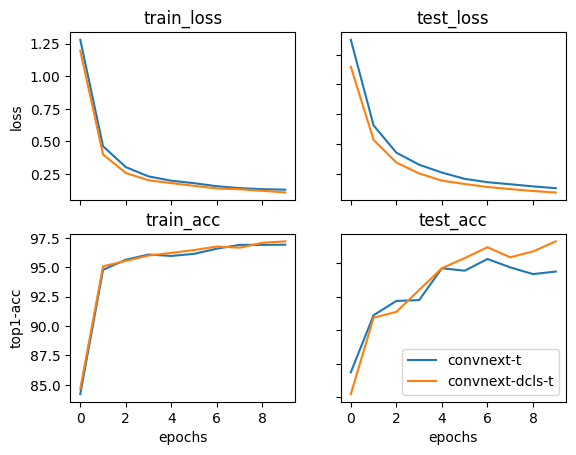

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(convnext_tiny_stats['train_loss'], label='convnext-t')
axs[0, 0].plot(convnext_dcls_gauss_tiny_stats['train_loss'], label='convnext-dcls-t')
axs[0, 0].set_title('train_loss')
axs[0, 1].plot(convnext_tiny_stats['test_loss'], label='convnext-t')
axs[0, 1].plot(convnext_dcls_gauss_tiny_stats['test_loss'], label='convnext-dcls-t')
axs[0, 1].set_title('test_loss')
axs[1, 0].plot(convnext_tiny_stats['train_acc'], label='convnext-t')
axs[1, 0].plot(convnext_dcls_gauss_tiny_stats['train_acc'], label='convnext-dcls-t')
axs[1, 0].set_title('train_acc')
axs[1, 1].plot(convnext_tiny_stats['test_acc'], label='convnext-t')
axs[1, 1].plot(convnext_dcls_gauss_tiny_stats['test_acc'], label='convnext-dcls-t')
axs[1, 1].set_title('test_acc')

for ax in axs.flat[:1]:
    ax.set(xlabel='epochs', ylabel='loss')
for ax in axs.flat[2:]:
    ax.set(xlabel='epochs', ylabel='top1-acc')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

ax.legend()
fig.show()

# Conclusion
Based on the observations from the last plot, it is evident that the pretrained ConvNeXt-T model with DCLS outperforms the pretrained baseline in terms of train and test losses as well as test accuracy for the fine-tuning task on STL-10, while having the same number of trainable parameters.

Additionally, it is worth noting that the ConvNeXt-T model took approximately 205 seconds on a single T4 gpu to complete the 10 fine-tuning epochs, while the ConvNeXt-DCLS-T model took around 310 seconds to achieve the same. This discrepancy is attributed to the larger kernel size utilized in the DCLS method (23 by 23 compared to the baseline's 7 by 7).

To achieve a similar throughput, and as raised by the warning: "WARNING:root:DepthWiseConv2dImplicitGEMM not installed, switching to native conv2d",  it is recommended  to install the DepthWiseConv2dImplicitGEMM, developed by [MegEngine](https://github.com/MegEngine/cutlass), instead of the native PyTorch Conv2d. To install and enable the DepthWiseConv2dImplicitGEMM, please follow the instructions of [RepLKNet](https://github.com/DingXiaoH/RepLKNet-pytorch#use-our-efficient-large-kernel-convolution-with-pytorch).